In [1]:
import rpSBML
import rpGraph
import rpDraw
import matplotlib.pyplot as plt
import networkx as nx
import logging
from rdkit.Chem import MolFromInchi
from rdkit.Chem import Draw
import copy
import json
import re
import drawSvg as draw
import svgutils.transform as sg

In [2]:
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)
logging.basicConfig(level=logging.NOTSET)

logging.basicConfig(
    level=logging.DEBUG,
    #level=logging.WARNING,
    #level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(levelname)s %(module)s - %(funcName)s: %(message)s',
    datefmt='%d-%m-%Y %H:%M:%S',
)

In [3]:
#root_path = '/home/mdulac/Downloads/'
root_path = '/Users/melchior/Downloads/'

#rpsbml = rpSBML.rpSBML('test', path='rp_1_3.sbml.xml')
#BUG BUG in the ordering of reactions
#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy1442-[FBA]/rp_3_8.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy1442-[FBA]/rp_18_1.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy1442-[FBA]/rp_16_1.sbml.xml')

#rpsbml = rpSBML.rpSBML('test', path=root_path+'Galaxy225-[Ranked_Pathways]/rp_1_3.sbml.xml')

#rpsbml = rpSBML.rpSBML('test', path=root_path+'rpglobalscore_101/rp_5_4.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path='/home/mdulac/Downloads/rpglobalscore_104/rp_5_1.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path='/home/mdulac/Downloads/rpglobalscore_104/rp_36_1.sbml.xml')
#rpsbml = rpSBML.rpSBML('test', path='/home/mdulac/Downloads/rpglobalscore_104/rp_47_2.sbml.xml')
rpsbml = rpSBML.rpSBML('test', path='/home/mdulac/Downloads/rpglobalscore_104/rp_61_1.sbml.xml')


rpgraph = rpGraph.rpGraph(rpsbml)
rpdraw = rpDraw.rpDraw()
target = [i for i in list(rpgraph.G.nodes) if 'TARGET' in i][0]

DEBUG:rpSBML:Started instance of rpSBML
DEBUG:rpGraph:Started instance of rpGraph


In [4]:
arrowhead = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient='auto', id='normal_arrow')
arrowhead.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='black', close=True))
arrowhead_flat = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient=0, id='flat_arrow')
arrowhead_flat.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='black', close=True))
rev_arrowhead = draw.Marker(-0.1, -0.5, 0.9, 0.5, scale=4, orient=0, id='rev_flat_arrow')
rev_arrowhead.append(draw.Lines(-0.1, -0.5, -0.1, 0.5, 0.9, 0, fill='black', close=True))
arrowhead_comp_x = 7.0
arrowhead_comp_y = 7.0

In [5]:
def drawChemicalList(id_inchi, subplot_size=[200, 200]):
    toRet = {}
    inchi_list = list(set([id_inchi[i] for i in id_inchi]))
    list_mol = [MolFromInchi(inchi) for inchi in inchi_list]
    for i in range(len(list_mol)):
        cp_list_mol = copy.deepcopy(list_mol)
        cp_list_mol.pop(i)
        tmp_list_mol = [list_mol[i]]+cp_list_mol
        img = Draw.MolsToGridImage(tmp_list_mol, molsPerRow=1, subImgSize=(subplot_size[0], subplot_size[1]), useSVG=True)
        #add the groups tag with the id's of the reactions -- should have be size width=subplot_size[0] height=subplot_size[1]*len(list_mol)
        bond_0_count = 0
        svg_str = ''
        for line in img.splitlines():
            add_line = True
            m0 = re.findall("(\d+\.\d+)", line)
            if m0:
                for y in m0:
                    if float(y)>subplot_size[1]:
                        add_line = False
            m1 = re.findall("height=\'\d+", line)
            if m1:
                line = re.sub(r"height=\'\d+", "height=\'"+str(subplot_size[1]), line)
                #line.replace(str(subplot_size[i]*len(list_mol)), str(subplot_size[1]))
            if add_line:
                svg_str += line+'\n'
        for y in id_inchi:
            if id_inchi[y]==inchi_list[i]:
                toRet[y] = svg_str
    return toRet

In [6]:
def graph_svg(G,
              target,
              subplot_size=[200,200],
              reac_size=[20,60],
              reac_fill_color='#ddd',
              reac_stroke_color='black',
              reac_stroke_width=2,
              arrow_gap_size=100,
              arrow_stroke_color='black',
              arrow_stroke_width=2,
              plot_only_central=False,
              filter_cofactors=True,
              filter_sink_species=True):
    #gather all the inchis and convert to svg
    resG, pos = rpdraw._hierarchy_pos(G, 
                                      target, 
                                      plot_only_central=plot_only_central, 
                                      filter_cofactors=filter_cofactors,
                                      filter_sink_species=filter_sink_species)
    print(pos)
    id_inchi = {}

    #first stack the 
    print('============================')
    pathway_layers = []
    ordered_y = sorted(list(set([pos[i][1] for i in pos])))
    for layer_y_loc in ordered_y:
        ordered_x = sorted(list(set([pos[i][0] for i in pos if pos[i][1]==layer_y_loc])))
        reaction = []
        for layer_x_loc in ordered_x:
            for node_id in pos:
                if pos[node_id][1]==layer_y_loc and pos[node_id][0]==layer_x_loc:
                    n = resG.nodes.get(node_id)
                    reaction.append(node_id)
                    break
        pathway_layers.append(reaction)
    print('pathway_layers: '+str(pathway_layers))
    print('============================')
    x_len = subplot_size[0]*len(pathway_layers)
    len_max_y = max([len(i) for i in pathway_layers])
    y_len = subplot_size[1]*len_max_y
    #make the fig white
    fig = sg.SVGFigure(str(x_len), str(y_len))
    #add a white background to the full image
    background = draw.Drawing(x_len, y_len, origin=(0,0))
    """
    d = draw.Drawing(x_len, y_len, origin=(0,0))
    d.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(d.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    """
    #######################
    x_move = 0
    print('############ Chem/Reac ###############')
    print('len_max_y: '+str(len_max_y))
    print('x_len: '+str(x_len))
    print('y_len: '+str(y_len))
    nodes_attach_locs = {}
    for layer in pathway_layers:
        y_move = 0
        y_shift = (y_len-subplot_size[1]*len(layer))/2
        print('====== y_shift: '+str(y_shift)+' =====')
        for cid in layer:
            node = G.node.get(cid)
            if node['type']=='species':
                print('\tSpecies: '+str(cid))
                print('\tx: '+str(x_move))
                print('\ty: '+str(y_move+y_shift))
                print('\tleft: '+str((x_move, y_len/len(layer)/2)))
                print('\tright: '+str((x_move+subplot_size[0], y_len/len(layer)/2)))
                print('\t-------------------------------')
                f = sg.fromstring(id_svg[cid])
                p = f.getroot()
                p.moveto(x_move, y_move+y_shift)
                fig.append(p)
                nodes_attach_locs[cid] = {'left': (x_move, y_len/len(layer)/2), 
                                          'right': (x_move+subplot_size[0], y_len/len(layer)/2)}
            if node['type']=='reaction':
                #draw the reaction rectangle
                print('\tReaction: '+str(cid))
                d = draw.Drawing(subplot_size[0], subplot_size[1], origin=(0,0))
                d.append(draw.Rectangle(0, 0, subplot_size[0], subplot_size[1], fill='#FFFFFF'))
                #add white backgroung TODO perhaps add blurry
                reac_x = subplot_size[0]/2-reac_size[0]*len_max_y/2
                print('\tx: '+str(reac_x))
                reac_y = subplot_size[1]/2-reac_size[1]/2
                print('\ty: '+str(reac_y))
                edge_x = subplot_size[0]/2-reac_size[1]/2                
                edge_y = subplot_size[1]/2-reac_size[0]/2
                print('\tedge_x: '+str(edge_x))
                print('\tedge_y: '+str(edge_y))
                print('\treac_x: '+str(reac_x))
                print('\treac_y: '+str(reac_y))
                #left = (x_move+edge_x, y_shift+reac_y)
                left = (x_move+edge_x, y_shift+subplot_size[1]/2)
                print('\tleft: '+str(left))
                #right = (x_move+edge_x+reac_size[1], y_shift+reac_y)
                right = (x_move+edge_x+reac_size[1], y_shift+subplot_size[1]/2)
                print('\tright: '+str(right))
                print('\t-------------------------------')
                d.append(draw.Rectangle(edge_x,
                                        edge_y,
                                        reac_size[1],
                                        reac_size[0],
                                        fill=reac_fill_color,
                                        stroke_width=reac_stroke_width,
                                        stroke=reac_stroke_color))
                a = sg.fromstring(d.asSvg())
                a_r = a.getroot()
                a_r.moveto(x_move, y_move+y_shift+subplot_size[1]) #WARNING: not sure why I have to + subpot
                fig.append(a_r)
                print('edge_y: '+str(edge_y))
                print('y_move: '+str(y_move))
                print('y_shift: '+str(y_shift))
                print('subplot_size[1]: '+str(subplot_size[1]))
                print(subplot_size[1]-y_shift)
                print(subplot_size[1]*len_max_y/2)
                nodes_attach_locs[cid] = {'left': left,
                                          'right': right}
                """
                nodes_attach_locs[cid] = {'left': (x_move+edge_x, 
                                                   y_move+y_shift+subplot_size[1]), 
                                          'right': (x_move+edge_x+reac_size[1], 
                                                    y_move+y_shift+subplot_size[1]+edge_y-reac_size[0]/2)}
                """
            y_move += subplot_size[1]
            #layer_num += 1
        x_move += subplot_size[0]
    print('nodes_attach_locs: '+str(nodes_attach_locs))
    ######## draw the lines #############
    print('############ Arrows ###############')
    for edge in list(resG.edges):
        print('\t---------- edge: '+str(edge)+' -----------')
        source_x = nodes_attach_locs[edge[0]]['right'][0]
        print('\tsource_x: '+str(source_x))
        source_y = nodes_attach_locs[edge[0]]['right'][1]
        print('\tsource_y: '+str(source_y))
        target_x = nodes_attach_locs[edge[1]]['left'][0]
        print('\ttarget_x: '+str(target_x))
        target_y = nodes_attach_locs[edge[1]]['left'][1]
        print('\ttarget_y: '+str(target_y))
        line_x = max([source_x, target_x])-min([source_x, target_x])
        print('\tline_x: '+str(line_x))
        line_y = max([source_y, target_y])-min([source_y, target_y])
        print('\tline_y: '+str(line_y))
        #d = draw.Drawing(x_len, y_len, origin=(0,0))
        '''
        p = draw.Path(stroke=arrow_stroke_color,
                      stroke_width=arrow_stroke_width,
                      fill='transparent',
                      marker_end=arrowhead_flat)
        p.M(source_x, source_y).C(arrow_gap_size-source_x,
                                                 source_y,
                                                 source_x,
                                                 source_y,
                                                 target_x,
                                                 target_y)
        '''
        background.append(draw.Line(source_x,
                           source_y,
                           target_x,
                           target_y,
                           stroke='red',
                           stroke_width=2,
                           fill='none',
                           marker_end=arrowhead))  # Add an arrow to the end of a line
        '''
        d.append(p)
        arrow = sg.fromstring(d.asSvg())
        a_b = arrow.getroot()
        a_b.moveto(0, line_y) #not sure why I have to move this
        fig.append(a_b)
        '''
    #background.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(background.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    svg = fig.to_str().decode("utf-8")
    open('test.svg', 'w').write(svg)

In [10]:
graph_svg(rpgraph.G, [i for i in rpgraph.G.nodes if 'TARGET' in i][0])

DEBUG:rpDraw:--------- MNXM438__64__MNXC3 ---------
DEBUG:rpDraw:--------- RP5 ---------
DEBUG:rpDraw:--------- CMPD_0000000008__64__MNXC3 ---------
DEBUG:rpDraw:--------- RP6 ---------
DEBUG:rpDraw:--------- CMPD_0000000004__64__MNXC3 ---------
DEBUG:rpDraw:--------- RP3 ---------
DEBUG:rpDraw:--------- RP4 ---------
DEBUG:rpDraw:--------- MNXM3__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM3__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- MNXM5__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM5__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- RP2 ---------
DEBUG:rpDraw:--------- MNXM6__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM6__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- MNXM153__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM12__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM12__64__MNXC3 is a list cofactor a

DEBUG:rpDraw:toadd_nodes: ['MNXM438__64__MNXC3', 'RP5', 'RP6', 'RP4', 'MNXM153__64__MNXC3', 'CMPD_0000000024__64__MNXC3']
DEBUG:rpDraw:parent_layer: ['CMPD_0000000018__64__MNXC3', 'CMPD_0000000019__64__MNXC3']
DEBUG:rpDraw:	CMPD_0000000018__64__MNXC3 --> ['RP4', 'RP3']
DEBUG:rpDraw:	Adding node: RP4
DEBUG:rpDraw:	RP4 predecessors: ['CMPD_0000000024__64__MNXC3', 'MNXM4__64__MNXC3', 'MNXM1__64__MNXC3', 'MNXM6__64__MNXC3']
DEBUG:rpDraw:		CMPD_0000000024__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM4__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM1__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM6__64__MNXC3 type: species
DEBUG:rpDraw:	CMPD_0000000019__64__MNXC3 --> ['RP5', 'RP3']
DEBUG:rpDraw:	Adding node: RP5
DEBUG:rpDraw:	RP5 predecessors: ['MNXM1__64__MNXC3', 'MNXM153__64__MNXC3', 'MNXM6__64__MNXC3']
DEBUG:rpDraw:		MNXM1__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM153__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM6__64__MNXC3 type: species
DEBUG:rpDraw:layer: ['RP4', 'RP5']
DEBUG:rpDraw:pos: {'T

False
True
True
{'TARGET_0000000001__64__MNXC3': (0.5, 0.0), 'RP1': (0.5, -0.2), 'CMPD_0000000004__64__MNXC3': (0.5, -0.4), 'RP2': (0.5, -0.6000000000000001), 'CMPD_0000000008__64__MNXC3': (0.5, -0.8), 'RP3': (0.5, -1.0), 'CMPD_0000000018__64__MNXC3': (0.25, -1.2), 'CMPD_0000000019__64__MNXC3': (0.75, -1.2), 'RP4': (0.25, -1.4), 'RP5': (0.75, -1.4), 'CMPD_0000000024__64__MNXC3': (0.25, -1.5999999999999999), 'MNXM153__64__MNXC3': (0.75, -1.5999999999999999), 'RP6': (0.5, -1.7999999999999998), 'MNXM438__64__MNXC3': (0.5, -1.9999999999999998)}
TARGET_0000000001__64__MNXC3
{'type': 'species', 'name': '(R)-rosmarinate', 'miriam': {'inchikey': ['DOUMFZQKYFQNTF-UHFFFAOYSA-N'], 'seed': ['cpd01273'], 'metacyc': ['CPD-6981'], 'hmdb': ['HMDB02887', 'HMDB03572'], 'metanetx': ['MNXM723125', 'MNXM3355', 'MNXM722836'], 'chebi': ['92370', '71493', '58062', '50371', '8895', '8894', '26582', '15055', '17226']}, 'brsynth': {'dfG_prime_m': {'units': 'kj_per_mol', 'value': -484.76286489801964}, 'dfG_uncert

DEBUG:rpDraw:--------- RP1 ---------
DEBUG:rpDraw:--------- RP2 ---------
DEBUG:rpDraw:--------- CMPD_0000000018__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM2__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM2__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- MNXM438__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM1__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM1__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- RP4 ---------
DEBUG:rpDraw:--------- RP6 ---------
DEBUG:rpDraw:--------- MNXM153__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM14__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM14__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- MNXM12__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM12__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- CMPD_0000000024__64__MNXC3 ---------
DEBUG:rpDraw:-------

DEBUG:rpDraw:toadd_nodes: ['MNXM438__64__MNXC3', 'RP4', 'RP6', 'MNXM153__64__MNXC3', 'CMPD_0000000024__64__MNXC3', 'RP5']
DEBUG:rpDraw:parent_layer: ['CMPD_0000000018__64__MNXC3', 'CMPD_0000000019__64__MNXC3']
DEBUG:rpDraw:	CMPD_0000000018__64__MNXC3 --> ['RP4', 'RP3']
DEBUG:rpDraw:	Adding node: RP4
DEBUG:rpDraw:	RP4 predecessors: ['CMPD_0000000024__64__MNXC3', 'MNXM4__64__MNXC3', 'MNXM1__64__MNXC3', 'MNXM6__64__MNXC3']
DEBUG:rpDraw:		CMPD_0000000024__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM4__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM1__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM6__64__MNXC3 type: species
DEBUG:rpDraw:	CMPD_0000000019__64__MNXC3 --> ['RP5', 'RP3']
DEBUG:rpDraw:	Adding node: RP5
DEBUG:rpDraw:	RP5 predecessors: ['MNXM1__64__MNXC3', 'MNXM153__64__MNXC3', 'MNXM6__64__MNXC3']
DEBUG:rpDraw:		MNXM1__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM153__64__MNXC3 type: species
DEBUG:rpDraw:		MNXM6__64__MNXC3 type: species
DEBUG:rpDraw:layer: ['RP4', 'RP5']
DEBUG:rpDraw:pos: {'T

DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUniIta.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmmi10' (cmmi10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisplay.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manag

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comicbd.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Georgia' (Georgia_Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerif.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Laksaman' (Laksaman.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Dyuthi' (Dyuthi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Droid Sans Fallback' (DroidSansFallbackFull.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Oblique.ttf) oblique normal 400 condensed>) = 1.25
DEBUG:matplotlib.fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Light.ttf) normal normal light normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Suruma' (Suruma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa' (padmaa.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstBook' (KacstBook.ttf) normal normal book normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Fo

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstDecorative' (KacstDecorative.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (arialbd.ttf) normal normal 700 normal>) = 6.698636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Malayalam' (Lohit-Malayalam.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa-Bold.1.1' (padmaa-Bold.1.1.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'LKLUG' (lklug.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-ThinItalic.ttf) italic normal 400 normal>) = 11.05
DEBUG

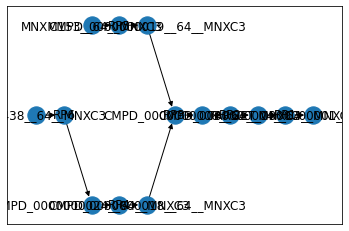

In [7]:
plot_only_central=False
filter_cofactors=True
filter_sink_species=True
#gather all the inchis and convert to svg
resG, pos = rpdraw._hierarchy_pos(rpgraph.G, 
                                  [i for i in rpgraph.G.nodes if 'TARGET' in i][0], 
                                  plot_only_central=plot_only_central, 
                                  filter_cofactors=filter_cofactors,
                                  filter_sink_species=filter_sink_species)
nx.draw_networkx(resG, pos=pos)

In [20]:
pos

{'TARGET_0000000001__64__MNXC3': (1.0, 0.5),
 'RP1': (0.9, 0.5),
 'CMPD_0000000004__64__MNXC3': (0.8, 0.5),
 'RP2': (0.7, 0.5),
 'CMPD_0000000008__64__MNXC3': (0.6, 0.5),
 'RP3': (0.5, 0.5),
 'CMPD_0000000018__64__MNXC3': (0.4, 0.0),
 'CMPD_0000000019__64__MNXC3': (0.4, 1.0),
 'RP4': (0.3, 0.0),
 'RP5': (0.3, 1.0),
 'CMPD_0000000024__64__MNXC3': (0.2, 0.0),
 'MNXM153__64__MNXC3': (0.2, 1.0),
 'RP6': (0.1, 0.5),
 'MNXM438__64__MNXC3': (0.0, 0.5)}

In [18]:
p = -0.1
min_p = -1.6
max_p = 0.0  

In [11]:
x_transform = -1.0
y_transform = -1.0
subplot_size = [200,200]
pathway_layers = []
ordered_y = sorted(list(set([pos[i][0] for i in pos])))
for layer_y_loc in ordered_y:
    ordered_x = sorted(list(set([pos[i][1] for i in pos if pos[i][0]==layer_y_loc])))
    reaction = []
    for layer_x_loc in ordered_x:
        for node_id in pos:
            if pos[node_id][0]==layer_y_loc and pos[node_id][1]==layer_x_loc:
                n = resG.nodes.get(node_id)
                reaction.append(node_id)
                break
    pathway_layers.append(reaction)

In [12]:
ordered_y

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [13]:
pathway_layers

[['MNXM438__64__MNXC3'],
 ['RP6'],
 ['CMPD_0000000024__64__MNXC3', 'MNXM153__64__MNXC3'],
 ['RP4', 'RP5'],
 ['CMPD_0000000018__64__MNXC3', 'CMPD_0000000019__64__MNXC3'],
 ['RP3'],
 ['CMPD_0000000008__64__MNXC3'],
 ['RP2'],
 ['CMPD_0000000004__64__MNXC3'],
 ['RP1'],
 ['TARGET_0000000001__64__MNXC3']]

In [17]:
x_len = subplot_size[0]*len(pathway_layers)
len_max_y = max([len(i) for i in pathway_layers])
y_len = subplot_size[1]*len_max_y

In [18]:
x_len

2200

In [19]:
y_len

400

In [23]:
mod_pos = {}
for node in pos:
    mod_pos[node] = (pos[node][0]*x_len, pos[node][1]*y_len)

In [25]:
mod_pos

{'TARGET_0000000001__64__MNXC3': (2200.0, 200.0),
 'RP1': (1980.0, 200.0),
 'CMPD_0000000004__64__MNXC3': (1760.0, 200.0),
 'RP2': (1540.0, 200.0),
 'CMPD_0000000008__64__MNXC3': (1320.0, 200.0),
 'RP3': (1100.0, 200.0),
 'CMPD_0000000018__64__MNXC3': (880.0, 0.0),
 'CMPD_0000000019__64__MNXC3': (880.0, 400.0),
 'RP4': (660.0, 0.0),
 'RP5': (660.0, 400.0),
 'CMPD_0000000024__64__MNXC3': (440.0, 0.0),
 'MNXM153__64__MNXC3': (440.0, 400.0),
 'RP6': (220.0, 200.0),
 'MNXM438__64__MNXC3': (0.0, 200.0)}

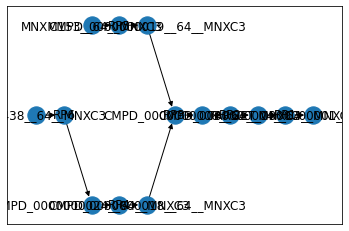

In [24]:
nx.draw_networkx(resG, pos=mod_pos)

In [28]:
id_inchi = {}
for node in list(rpgraph.G.nodes):
    if rpgraph.G.node.get(node)['type']=='species':
        print(node)
        print(rpgraph.G.node.get(node))
        id_inchi[node] = rpgraph.G.node.get(node)['brsynth']['inchi']
id_svg = drawChemicalList(id_inchi, subplot_size)

TARGET_0000000001__64__MNXC3
{'type': 'species', 'name': '(R)-rosmarinate', 'miriam': {'inchikey': ['DOUMFZQKYFQNTF-UHFFFAOYSA-N'], 'seed': ['cpd01273'], 'metacyc': ['CPD-6981'], 'hmdb': ['HMDB02887', 'HMDB03572'], 'metanetx': ['MNXM723125', 'MNXM3355', 'MNXM722836'], 'chebi': ['92370', '71493', '58062', '50371', '8895', '8894', '26582', '15055', '17226']}, 'brsynth': {'dfG_prime_m': {'units': 'kj_per_mol', 'value': -484.76286489801964}, 'dfG_uncert': {'units': 'kj_per_mol', 'value': 15.659739788964734}, 'dfG_prime_o': {'units': 'kj_per_mol', 'value': -467.64802736329864}, 'smiles': '[H]OC(=O)C([H])(OC(=O)C([H])=C([H])c1c([H])c([H])c(O[H])c(O[H])c1[H])C([H])([H])c1c([H])c([H])c(O[H])c(O[H])c1[H]', 'inchi': 'InChI=1S/C18H16O8/c19-12-4-1-10(7-14(12)21)3-6-17(23)26-16(18(24)25)9-11-2-5-13(20)15(22)8-11/h1-8,16,19-22H,9H2,(H,24,25)', 'inchikey': 'DOUMFZQKYFQNTF-UHFFFAOYSA-N'}, 'central_species': True, 'sink_species': False}
MNXM5__64__MNXC3
{'type': 'species', 'name': 'NADP(+)', 'miriam': 

In [29]:
id_svg.keys()

dict_keys(['MNXM12__64__MNXC3', 'MNXM4__64__MNXC3', 'CMPD_0000000004__64__MNXC3', 'MNXM5__64__MNXC3', 'CMPD_0000000024__64__MNXC3', 'MNXM438__64__MNXC3', 'MNXM3__64__MNXC3', 'MNXM2__64__MNXC3', 'MNXM11__64__MNXC3', 'CMPD_0000000008__64__MNXC3', 'TARGET_0000000001__64__MNXC3', 'CMPD_0000000019__64__MNXC3', 'MNXM153__64__MNXC3', 'MNXM14__64__MNXC3', 'MNXM6__64__MNXC3', 'CMPD_0000000018__64__MNXC3', 'MNXM1__64__MNXC3'])

In [30]:
fig = sg.SVGFigure(str(100), str(100))

In [31]:
f = sg.fromstring(id_svg['MNXM12__64__MNXC3'])

In [33]:
p = f.getroot()

In [34]:
p

In [ ]:
fig.append()

In [ ]:
def graph_svg(G,
              target,
              subplot_size=[200,200],
              reac_size=[20,60],
              reac_fill_color='#ddd',
              reac_stroke_color='black',
              reac_stroke_width=2,
              arrow_gap_size=100,
              arrow_stroke_color='black',
              arrow_stroke_width=2,
              plot_only_central=False,
              filter_cofactors=True,
              filter_sink_species=True):
    #gather all the inchis and convert to svg
    resG, pos = rpdraw._hierarchy_pos(G, 
                                      target, 
                                      plot_only_central=plot_only_central, 
                                      filter_cofactors=filter_cofactors,
                                      filter_sink_species=filter_sink_species)
    id_inchi = {}
    for node in list(resG.nodes):
        if resG.node.get(node)['type']=='species':
            print(node)
            print(resG.node.get(node))
            id_inchi[node] = resG.node.get(node)['brsynth']['inchi']
    id_svg = drawChemicalList(id_inchi, subplot_size)
    print('============================')
    subplot_size = [200,200]
    pathway_layers = []
    ordered_y = sorted(list(set([pos[i][0] for i in pos])))
    for layer_y_loc in ordered_y:
        ordered_x = sorted(list(set([pos[i][1] for i in pos if pos[i][0]==layer_y_loc])))
        reaction = []
        for layer_x_loc in ordered_x:
            for node_id in pos:
                if pos[node_id][0]==layer_y_loc and pos[node_id][1]==layer_x_loc:
                    n = resG.nodes.get(node_id)
                    reaction.append(node_id)
                    break
        pathway_layers.append(reaction)
    print('pathway_layers: '+str(pathway_layers))
    print('============================')
    x_len = subplot_size[0]*len(pathway_layers)
    len_max_y = max([len(i) for i in pathway_layers])
    y_len = subplot_size[1]*len_max_y
    mod_pos = {}
    for node in pos:
        mod_pos[node] = (pos[node][0]*x_len, pos[node][1]*y_len)
    #make the fig white
    fig = sg.SVGFigure(str(x_len), str(y_len))
    #add a white background to the full image
    background = draw.Drawing(x_len, y_len, origin=(0,0))
    """
    d = draw.Drawing(x_len, y_len, origin=(0,0))
    d.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(d.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    """
    #######################
    x_move = 0
    print('############ Chem/Reac ###############')
    print('len_max_y: '+str(len_max_y))
    print('x_len: '+str(x_len))
    print('y_len: '+str(y_len))
    nodes_attach_locs = {}
    for layer in pathway_layers:
        y_move = 0
        y_shift = (y_len-subplot_size[1]*len(layer))/2
        print('====== y_shift: '+str(y_shift)+' =====')
        for cid in layer:
            node = G.node.get(cid)
            if node['type']=='species':
                print('\tSpecies: '+str(cid))
                print('\tx: '+str(x_move))
                print('\ty: '+str(y_move+y_shift))
                print('\tleft: '+str((x_move, y_len/len(layer)/2)))
                print('\tright: '+str((x_move+subplot_size[0], y_len/len(layer)/2)))
                print('\t-------------------------------')
                f = sg.fromstring(id_svg[cid])
                p = f.getroot()
                p.moveto(x_move, y_move+y_shift)
                fig.append(p)
                nodes_attach_locs[cid] = {'left': (x_move, y_len/len(layer)/2), 
                                          'right': (x_move+subplot_size[0], y_len/len(layer)/2)}
            if node['type']=='reaction':
                #draw the reaction rectangle
                print('\tReaction: '+str(cid))
                d = draw.Drawing(subplot_size[0], subplot_size[1], origin=(0,0))
                d.append(draw.Rectangle(0, 0, subplot_size[0], subplot_size[1], fill='#FFFFFF'))
                #add white backgroung TODO perhaps add blurry
                reac_x = subplot_size[0]/2-reac_size[0]*len_max_y/2
                print('\tx: '+str(reac_x))
                reac_y = subplot_size[1]/2-reac_size[1]/2
                print('\ty: '+str(reac_y))
                edge_x = subplot_size[0]/2-reac_size[1]/2                
                edge_y = subplot_size[1]/2-reac_size[0]/2
                print('\tedge_x: '+str(edge_x))
                print('\tedge_y: '+str(edge_y))
                print('\treac_x: '+str(reac_x))
                print('\treac_y: '+str(reac_y))
                #left = (x_move+edge_x, y_shift+reac_y)
                left = (x_move+edge_x, y_shift+subplot_size[1]/2)
                print('\tleft: '+str(left))
                #right = (x_move+edge_x+reac_size[1], y_shift+reac_y)
                right = (x_move+edge_x+reac_size[1], y_shift+subplot_size[1]/2)
                print('\tright: '+str(right))
                print('\t-------------------------------')
                d.append(draw.Rectangle(edge_x,
                                        edge_y,
                                        reac_size[1],
                                        reac_size[0],
                                        fill=reac_fill_color,
                                        stroke_width=reac_stroke_width,
                                        stroke=reac_stroke_color))
                a = sg.fromstring(d.asSvg())
                a_r = a.getroot()
                a_r.moveto(x_move, y_move+y_shift+subplot_size[1]) #WARNING: not sure why I have to + subpot
                fig.append(a_r)
                print('edge_y: '+str(edge_y))
                print('y_move: '+str(y_move))
                print('y_shift: '+str(y_shift))
                print('subplot_size[1]: '+str(subplot_size[1]))
                print(subplot_size[1]-y_shift)
                print(subplot_size[1]*len_max_y/2)
                nodes_attach_locs[cid] = {'left': left,
                                          'right': right}
                """
                nodes_attach_locs[cid] = {'left': (x_move+edge_x, 
                                                   y_move+y_shift+subplot_size[1]), 
                                          'right': (x_move+edge_x+reac_size[1], 
                                                    y_move+y_shift+subplot_size[1]+edge_y-reac_size[0]/2)}
                """
            y_move += subplot_size[1]
            #layer_num += 1
        x_move += subplot_size[0]
    print('nodes_attach_locs: '+str(nodes_attach_locs))
    ######## draw the lines #############
    print('############ Arrows ###############')
    for edge in list(resG.edges):
        print('\t---------- edge: '+str(edge)+' -----------')
        source_x = nodes_attach_locs[edge[0]]['right'][0]
        print('\tsource_x: '+str(source_x))
        source_y = nodes_attach_locs[edge[0]]['right'][1]
        print('\tsource_y: '+str(source_y))
        target_x = nodes_attach_locs[edge[1]]['left'][0]
        print('\ttarget_x: '+str(target_x))
        target_y = nodes_attach_locs[edge[1]]['left'][1]
        print('\ttarget_y: '+str(target_y))
        line_x = max([source_x, target_x])-min([source_x, target_x])
        print('\tline_x: '+str(line_x))
        line_y = max([source_y, target_y])-min([source_y, target_y])
        print('\tline_y: '+str(line_y))
        #d = draw.Drawing(x_len, y_len, origin=(0,0))
        '''
        p = draw.Path(stroke=arrow_stroke_color,
                      stroke_width=arrow_stroke_width,
                      fill='transparent',
                      marker_end=arrowhead_flat)
        p.M(source_x, source_y).C(arrow_gap_size-source_x,
                                                 source_y,
                                                 source_x,
                                                 source_y,
                                                 target_x,
                                                 target_y)
        '''
        background.append(draw.Line(source_x,
                           source_y,
                           target_x,
                           target_y,
                           stroke='red',
                           stroke_width=2,
                           fill='none',
                           marker_end=arrowhead))  # Add an arrow to the end of a line
        '''
        d.append(p)
        arrow = sg.fromstring(d.asSvg())
        a_b = arrow.getroot()
        a_b.moveto(0, line_y) #not sure why I have to move this
        fig.append(a_b)
        '''
    #background.append(draw.Rectangle(0, 0, x_len, y_len, fill='#FFFFFF'))
    white_back = sg.fromstring(background.asSvg())
    w_b = white_back.getroot()
    w_b.moveto(0, y_len) #not sure why I have to move this
    fig.append(w_b)
    svg = fig.to_str().decode("utf-8")
    open('test.svg', 'w').write(svg)

In [ ]:
graph_svg(rpgraph.G, [i for i in rpgraph.G.nodes if 'TARGET' in i][0])

In [7]:

def newdraw(G,
          target,
          subplot_size=[200,200],
          reac_size=[20,60],
          reac_fill_color='#ddd',
          reac_stroke_color='black',
          reac_stroke_width=2,
          arrow_stroke_color='black',
          arrow_stroke_width=2,
          plot_only_central=True,
          filter_cofactors=True,
          filter_sink_species=True):
    #gather all the inchis and convert to svg
    resG, pos = rpdraw._hierarchy_pos(G, 
                                      target, 
                                      plot_only_central=plot_only_central, 
                                      filter_cofactors=filter_cofactors,
                                      filter_sink_species=filter_sink_species)
    id_inchi = {}
    print('pos: '+str(pos))
    for node in list(resG.nodes):
        if resG.node.get(node)['type']=='species':
            print(resG.node.get(node))
            id_inchi[node] = resG.node.get(node)['brsynth']['inchi']
    id_svg = drawChemicalList(id_inchi, subplot_size)
    print('============================')
    a = {}
    for n in pos:
        if not pos[n][0] in a:
            a[pos[n][0]] = []
        a[pos[n][0]].append(pos[n][1])
    largest_y = 0
    for i in a:
        if len(a[i])>largest_y:
            largest_y = len(a[i])
    u_x_layers = list(set([pos[i][0] for i in pos]))
    u_y_layers = list(set([pos[i][1] for i in pos]))
    print('u_x_layers: '+str(u_x_layers))
    print('u_y_layers: '+str(u_y_layers))
    background_len_x = subplot_size[0]*len(u_x_layers)
    background_len_y = subplot_size[1]*largest_y
    print('background_len_x: '+str(background_len_x))
    print('background_len_y: '+str(background_len_y))
    mod_pos = {}
    for node in pos:
        mod_pos[node] = (pos[node][0]*background_len_x*(200/225),
                         (pos[node][1]*background_len_y))
    print('============================')
    print('mod_pos: '+str(mod_pos))
    ########### draw the background #############
    len_fig_x = (background_len_x+subplot_size[0])*(200/225)
    len_fig_y = background_len_y+subplot_size[1]
    print('len_fig_x: '+str(len_fig_x))
    print('len_fig_y: '+str(len_fig_y))
    '''
    fig = sg.SVGFigure(str((background_len_x+subplot_size[0])*(200/225)),
                       str(background_len_y+subplot_size[1]))
    '''
    fig = sg.SVGFigure(str(len_fig_x),
                       str(len_fig_y))
    background = draw.Drawing(len_fig_x, len_fig_y, origin=(0,0))
    background_white = draw.Drawing(len_fig_x, len_fig_y, origin=(0,0))
    background_white.append(draw.Rectangle(0, 0, len_fig_x, len_fig_y, fill='#FFFFFF'))
    a = sg.fromstring(background_white.asSvg())
    b_w = a.getroot()
    b_w.moveto(0, background_len_y+subplot_size[1])#WARNING: not sure why I have to + subpot
    fig.append(b_w)
    nodes_attach_locs = {}
    for node_id in mod_pos:
        node = G.node.get(node_id)
        print('\tSpecies: '+str(node_id))
        if node['type']=='species':
            print('\tNode pos: '+str(mod_pos[node_id]))
            print('\tx: '+str(mod_pos[node_id][0]))
            print('\ty: '+str(mod_pos[node_id][1]))
            f = sg.fromstring(id_svg[node_id])
            p = f.getroot()
            p.moveto(mod_pos[node_id][0],
                     mod_pos[node_id][1])
            fig.append(p)
            nodes_attach_locs[node_id] = {'left': (mod_pos[node_id][0], 
                                                   mod_pos[node_id][1]-subplot_size[1]/2), 
                                          'right': (mod_pos[node_id][0]+subplot_size[0],
                                                    mod_pos[node_id][1]-subplot_size[1]/2)}
        elif node['type']=='reaction':
            """
            background.append(draw.Rectangle(mod_pos[node_id][0],#-subplot_size[0]/2,
                                            mod_pos[node_id][1],#-subplot_size[1]/2,
                                            reac_size[1],
                                            reac_size[0],
                                            fill=reac_fill_color,
                                            stroke_width=reac_stroke_width,
                                            stroke=reac_stroke_color))
            """
            d = draw.Drawing(subplot_size[0], subplot_size[1], origin=(0,0))
            d.append(draw.Rectangle(0, 0, subplot_size[0], subplot_size[1], fill='#FFFFFF'))
            edge_x = subplot_size[0]/2-reac_size[1]/2                
            edge_y = subplot_size[1]/2-reac_size[0]/2
            print('\tedge_x: '+str(edge_x))
            print('\tedge_y: '+str(edge_y))
            print('\tx: '+str(mod_pos[node_id][0]))
            print('\ty: '+str(mod_pos[node_id][1]+subplot_size[1]))
            #left = (x_move+edge_x, y_shift+subplot_size[1]/2)
            #right = (x_move+edge_x+reac_size[1], y_shift+subplot_size[1]/2)
            d.append(draw.Rectangle(edge_x,
                                edge_y,
                                reac_size[1],
                                reac_size[0],
                                fill=reac_fill_color,
                                stroke_width=reac_stroke_width,
                                stroke=reac_stroke_color))
            a = sg.fromstring(d.asSvg())
            a_r = a.getroot()
            a_r.moveto(mod_pos[node_id][0], 
                       mod_pos[node_id][1]+subplot_size[1]) #WARNING: not sure why I have to + subpot
            fig.append(a_r)
            nodes_attach_locs[node_id] = {'left': (mod_pos[node_id][0]+edge_x, 
                                                   mod_pos[node_id][1]-subplot_size[1]/2), 
                                          'right': (mod_pos[node_id][0]+subplot_size[0]-edge_x+reac_stroke_width/2,
                                                    mod_pos[node_id][1]-subplot_size[1]/2)}
        print('\t-------------------------------')
    for edge in list(resG.edges):
        print('\t---------- edge: '+str(edge)+' -----------')
        source_x = nodes_attach_locs[edge[0]]['right'][0]
        print('\tsource_x: '+str(source_x))
        source_y = nodes_attach_locs[edge[0]]['right'][1]
        print('\tsource_y: '+str(source_y))
        target_x = nodes_attach_locs[edge[1]]['left'][0]
        print('\ttarget_x: '+str(target_x))
        target_y = nodes_attach_locs[edge[1]]['left'][1]
        print('\ttarget_y: '+str(target_y))
        line_x = max([source_x, target_x])-min([source_x, target_x])
        print('\tline_x: '+str(line_x))
        line_y = max([source_y, target_y])-min([source_y, target_y])
        print('\tline_y: '+str(line_y))
        """
        background.append(draw.Line(source_x,
                           source_y,
                           target_x,
                           target_y,
                           stroke='red',
                           stroke_width=2,
                           fill='none',
                           marker_end=arrowhead))  # Add an arrow to the end of a line
        """
        p = draw.Path(stroke=arrow_stroke_color,
                      stroke_width=arrow_stroke_width,
                      fill='none',
                      marker_end=arrowhead_flat)
        p.M(source_x, source_y).C(#subplot_size[0]/2+source_x,
                                  subplot_size[0]/2-arrowhead_comp_x+source_x,
                                  source_y,
                                  source_x,
                                  target_y,
                                  target_x-arrowhead_comp_x,
                                  target_y)
        background.append(p)
    back = sg.fromstring(background.asSvg())
    b = back.getroot()
    b.moveto(0, background_len_y) #not sure why I have to move this
    fig.append(b)
    svg = fig.to_str().decode("utf-8")
    open('test.svg', 'w').write(svg)
    return resG, pos

In [8]:

resG, pos = newdraw(rpgraph.G, [i for i in rpgraph.G.nodes if 'TARGET' in i][0])


DEBUG:rpDraw:--------- MNXM1__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM1__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- TARGET_0000000001__64__MNXC3 ---------
DEBUG:rpDraw:--------- CMPD_0000000007__64__MNXC3 ---------
DEBUG:rpDraw:--------- CMPD_0000000022__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM223__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM962__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM13__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM13__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- RP8 ---------
DEBUG:rpDraw:--------- MNXM722800__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM509__64__MNXC3 ---------
DEBUG:rpDraw:--------- RP2 ---------
DEBUG:rpDraw:--------- MNXM89557__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM6__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM6__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- M

DEBUG:rpDraw:	MNXM21__64__MNXC3 predecessors: []
DEBUG:rpDraw:	RP2 --> ['CMPD_0000000010__64__MNXC3', 'MNXM1__64__MNXC3', 'MNXM6__64__MNXC3', 'CMPD_0000000007__64__MNXC3', 'MNXM5__64__MNXC3']
DEBUG:rpDraw:	Adding node: CMPD_0000000010__64__MNXC3
DEBUG:rpDraw:	CMPD_0000000010__64__MNXC3 predecessors: ['RP4']
DEBUG:rpDraw:		RP4 type: reaction
DEBUG:rpDraw:		RP4 successors: ['CMPD_0000000010__64__MNXC3', 'MNXM89557__64__MNXC3']
DEBUG:rpDraw:	Adding node: MNXM89557__64__MNXC3
DEBUG:rpDraw:layer: ['CMPD_0000000013__64__MNXC3', 'MNXM21__64__MNXC3', 'CMPD_0000000010__64__MNXC3', 'MNXM89557__64__MNXC3']
DEBUG:rpDraw:pos: {'TARGET_0000000001__64__MNXC3': (0.5, 0.0), 'RP1': (0.5, -0.2), 'CMPD_0000000006__64__MNXC3': (0.25, -0.4), 'CMPD_0000000007__64__MNXC3': (0.75, -0.4), 'RP3': (0.25, -0.6000000000000001), 'RP2': (0.75, -0.6000000000000001), 'CMPD_0000000013__64__MNXC3': (0.125, -0.8), 'MNXM21__64__MNXC3': (0.375, -0.8), 'CMPD_0000000010__64__MNXC3': (0.625, -0.8), 'MNXM89557__64__MNXC3': (0.8

DEBUG:rpDraw:	MNXM722714__64__MNXC3 predecessors: []
DEBUG:rpDraw:layer: ['CMPD_0000000037__64__MNXC3', 'MNXM962__64__MNXC3', 'MNXM23__64__MNXC3', 'MNXM509__64__MNXC3', 'MNXM76__64__MNXC3', 'MNXM722714__64__MNXC3']
DEBUG:rpDraw:pos: {'TARGET_0000000001__64__MNXC3': (0.5, 0.0), 'RP1': (0.5, -0.2), 'CMPD_0000000006__64__MNXC3': (0.25, -0.4), 'CMPD_0000000007__64__MNXC3': (0.75, -0.4), 'RP3': (0.25, -0.6000000000000001), 'RP2': (0.75, -0.6000000000000001), 'CMPD_0000000013__64__MNXC3': (0.125, -0.8), 'MNXM21__64__MNXC3': (0.375, -0.8), 'CMPD_0000000010__64__MNXC3': (0.625, -0.8), 'MNXM89557__64__MNXC3': (0.875, -0.8), 'RP5': (0.25, -1.0), 'RP4': (0.75, -1.0), 'CMPD_0000000022__64__MNXC3': (0.1, -1.2), 'MNXM223__64__MNXC3': (0.30000000000000004, -1.2), 'CMPD_0000000016__64__MNXC3': (0.5, -1.2), 'MNXM722800__64__MNXC3': (0.7, -1.2), 'MNXM20__64__MNXC3': (0.8999999999999999, -1.2), 'RP7': (0.25, -1.4), 'RP6': (0.75, -1.4), 'CMPD_0000000037__64__MNXC3': (0.08333333333333333, -1.59999999999999

pos: {'TARGET_0000000001__64__MNXC3': (1.0, 0.5), 'RP1': (0.9, 0.5), 'CMPD_0000000006__64__MNXC3': (0.8, 0.2), 'CMPD_0000000007__64__MNXC3': (0.8, 0.8), 'RP3': (0.7, 0.2), 'RP2': (0.7, 0.8), 'CMPD_0000000013__64__MNXC3': (0.6, 0.05), 'MNXM21__64__MNXC3': (0.6, 0.35), 'CMPD_0000000010__64__MNXC3': (0.6, 0.65), 'MNXM89557__64__MNXC3': (0.6, 0.95), 'RP5': (0.5, 0.2), 'RP4': (0.5, 0.8), 'CMPD_0000000022__64__MNXC3': (0.4, 0.02), 'MNXM223__64__MNXC3': (0.4, 0.26), 'CMPD_0000000016__64__MNXC3': (0.4, 0.5), 'MNXM722800__64__MNXC3': (0.4, 0.74), 'MNXM20__64__MNXC3': (0.4, 0.98), 'RP7': (0.3, 0.2), 'RP6': (0.3, 0.8), 'CMPD_0000000037__64__MNXC3': (0.2, 0.0), 'MNXM962__64__MNXC3': (0.2, 0.2), 'MNXM23__64__MNXC3': (0.2, 0.4), 'MNXM509__64__MNXC3': (0.2, 0.6), 'MNXM76__64__MNXC3': (0.2, 0.8), 'MNXM722714__64__MNXC3': (0.2, 1.0), 'RP8': (0.1, 0.5), 'MNXM2454__64__MNXC3': (0.0, 0.2), 'MNXM55__64__MNXC3': (0.0, 0.8)}
{'type': 'species', 'name': '(R)-rosmarinate', 'miriam': {'inchikey': ['DOUMFZQKYFQN

u_x_layers: [0.9, 1.0, 0.6, 0.8, 0.7, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
u_y_layers: [0.5, 0.8, 0.35, 0.2, 0.05, 0.65, 0.95, 0.26, 0.74, 0.98, 0.0, 0.4, 1.0, 0.02, 0.6]
background_len_x: 2200
background_len_y: 1200
mod_pos: {'TARGET_0000000001__64__MNXC3': (1955.5555555555554, 600.0), 'RP1': (1760.0, 600.0), 'CMPD_0000000006__64__MNXC3': (1564.4444444444443, 240.0), 'CMPD_0000000007__64__MNXC3': (1564.4444444444443, 960.0), 'RP3': (1368.888888888889, 240.0), 'RP2': (1368.888888888889, 960.0), 'CMPD_0000000013__64__MNXC3': (1173.3333333333333, 60.0), 'MNXM21__64__MNXC3': (1173.3333333333333, 420.0), 'CMPD_0000000010__64__MNXC3': (1173.3333333333333, 780.0), 'MNXM89557__64__MNXC3': (1173.3333333333333, 1140.0), 'RP5': (977.7777777777777, 240.0), 'RP4': (977.7777777777777, 960.0), 'CMPD_0000000022__64__MNXC3': (782.2222222222222, 24.0), 'MNXM223__64__MNXC3': (782.2222222222222, 312.0), 'CMPD_0000000016__64__MNXC3': (782.2222222222222, 600.0), 'MNXM722800__64__MNXC3': (782.2222222222222, 888.0)

In [ ]:
import glob
nx.draw_networkx(resG, pos=pos)

In [241]:
import glob
paths = glob.glob('/home/mdulac/Downloads/rpglobalscore_104/*')

In [245]:
import glob
for i in glob.glob('/home/mdulac/Downloads/rpglobalscore_104/*'):
    print(i)
    rpsbml = rpSBML.rpSBML('test', path=i)
    rpgraph = rpGraph.rpGraph(rpsbml)
    rpdraw = rpDraw.rpDraw()
    target = [i for i in list(rpgraph.G.nodes) if 'TARGET' in i][0]
    resG, pos = newdraw(rpgraph.G, target)
    nx.draw_networkx(resG, pos=pos)
    username = input("Enter username:")

DEBUG:rpSBML:Started instance of rpSBML
DEBUG:rpGraph:Started instance of rpGraph
DEBUG:rpDraw:--------- MNXM148067__64__MNXC3 ---------
DEBUG:rpDraw:--------- RP6 ---------
DEBUG:rpDraw:--------- RP7 ---------
DEBUG:rpDraw:--------- MNXM722800__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM12__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM12__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- MNXM1__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDraw:MNXM1__64__MNXC3 is a list cofactor and is filtered
DEBUG:rpDraw:--------- MNXM21__64__MNXC3 ---------
DEBUG:rpDraw:--------- CMPD_0000000013__64__MNXC3 ---------
DEBUG:rpDraw:--------- CMPD_0000000006__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM76__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM962__64__MNXC3 ---------
DEBUG:rpDraw:--------- CMPD_0000000037__64__MNXC3 ---------
DEBUG:rpDraw:--------- MNXM6__64__MNXC3 ---------
DEBUG:rpDraw:filter_cofactors: True
DEBUG:rpDr

DEBUG:rpDraw:	Adding node: MNXM148067__64__MNXC3
DEBUG:rpDraw:	Adding node: MNXM21__64__MNXC3
DEBUG:rpDraw:	MNXM21__64__MNXC3 predecessors: []
DEBUG:rpDraw:	RP2 --> ['CMPD_0000000010__64__MNXC3', 'MNXM1__64__MNXC3', 'MNXM6__64__MNXC3', 'CMPD_0000000007__64__MNXC3', 'MNXM5__64__MNXC3']
DEBUG:rpDraw:	Adding node: CMPD_0000000010__64__MNXC3
DEBUG:rpDraw:	CMPD_0000000010__64__MNXC3 predecessors: ['RP4']
DEBUG:rpDraw:		RP4 type: reaction
DEBUG:rpDraw:		RP4 successors: ['CMPD_0000000010__64__MNXC3', 'MNXM89557__64__MNXC3']
DEBUG:rpDraw:	Adding node: MNXM89557__64__MNXC3
DEBUG:rpDraw:layer: ['CMPD_0000000013__64__MNXC3', 'MNXM148067__64__MNXC3', 'MNXM21__64__MNXC3', 'CMPD_0000000010__64__MNXC3', 'MNXM89557__64__MNXC3']
DEBUG:rpDraw:pos: {'TARGET_0000000001__64__MNXC3': (0.5, 0.0), 'RP1': (0.5, -0.2), 'CMPD_0000000006__64__MNXC3': (0.25, -0.4), 'CMPD_0000000007__64__MNXC3': (0.75, -0.4), 'RP3': (0.25, -0.6000000000000001), 'RP2': (0.75, -0.6000000000000001), 'CMPD_0000000013__64__MNXC3': (0.1,

DEBUG:rpDraw:	Adding node: CMPD_0000000037__64__MNXC3
DEBUG:rpDraw:	CMPD_0000000037__64__MNXC3 predecessors: ['RP8']
DEBUG:rpDraw:		RP8 type: reaction
DEBUG:rpDraw:		RP8 successors: ['CMPD_0000000037__64__MNXC3', 'MNXM15__64__MNXC3', 'MNXM13__64__MNXC3', 'MNXM962__64__MNXC3', 'MNXM1__64__MNXC3', 'MNXM2__64__MNXC3', 'MNXM23__64__MNXC3']
DEBUG:rpDraw:	Adding node: MNXM962__64__MNXC3
DEBUG:rpDraw:	Adding node: MNXM23__64__MNXC3
DEBUG:rpDraw:	Adding node: MNXM509__64__MNXC3
DEBUG:rpDraw:	MNXM509__64__MNXC3 predecessors: []
DEBUG:rpDraw:	RP6 --> ['MNXM4__64__MNXC3', 'MNXM76__64__MNXC3', 'MNXM722714__64__MNXC3', 'CMPD_0000000016__64__MNXC3', 'MNXM722800__64__MNXC3']
DEBUG:rpDraw:	Adding node: MNXM76__64__MNXC3
DEBUG:rpDraw:	MNXM76__64__MNXC3 predecessors: []
DEBUG:rpDraw:	Adding node: MNXM722714__64__MNXC3
DEBUG:rpDraw:	MNXM722714__64__MNXC3 predecessors: []
DEBUG:rpDraw:layer: ['CMPD_0000000037__64__MNXC3', 'MNXM962__64__MNXC3', 'MNXM23__64__MNXC3', 'MNXM509__64__MNXC3', 'MNXM76__64__MNXC3'

pos: {'TARGET_0000000001__64__MNXC3': (1.0, 0.5), 'RP1': (0.9, 0.5), 'CMPD_0000000006__64__MNXC3': (0.8, 0.2), 'CMPD_0000000007__64__MNXC3': (0.8, 0.8), 'RP3': (0.7, 0.2), 'RP2': (0.7, 0.8), 'CMPD_0000000013__64__MNXC3': (0.6, 0.02), 'MNXM148067__64__MNXC3': (0.6, 0.26), 'MNXM21__64__MNXC3': (0.6, 0.5), 'CMPD_0000000010__64__MNXC3': (0.6, 0.74), 'MNXM89557__64__MNXC3': (0.6, 0.98), 'RP5': (0.5, 0.2), 'RP4': (0.5, 0.8), 'CMPD_0000000022__64__MNXC3': (0.4, 0.0), 'MNXM223__64__MNXC3': (0.4, 0.2), 'MNXM148013__64__MNXC3': (0.4, 0.4), 'CMPD_0000000016__64__MNXC3': (0.4, 0.6), 'MNXM722800__64__MNXC3': (0.4, 0.8), 'MNXM20__64__MNXC3': (0.4, 1.0), 'RP7': (0.3, 0.2), 'RP6': (0.3, 0.8), 'CMPD_0000000037__64__MNXC3': (0.2, 0.0), 'MNXM962__64__MNXC3': (0.2, 0.2), 'MNXM23__64__MNXC3': (0.2, 0.4), 'MNXM509__64__MNXC3': (0.2, 0.6), 'MNXM76__64__MNXC3': (0.2, 0.8), 'MNXM722714__64__MNXC3': (0.2, 1.0), 'RP8': (0.1, 0.5), 'MNXM2454__64__MNXC3': (0.0, 0.2), 'MNXM55__64__MNXC3': (0.0, 0.8)}


KeyError: 'inchi'

/home/mdulac/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mdulac/anaconda3/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 norm

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Verdana' (Verdana.ttf) normal normal 400 normal>) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Semibold.ttf) normal normal semibold normal>) = 10.24
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-LightItalic.ttf) italic normal light normal>) = 11.24
DEBUG:matplotlib.font_manager:findfont: s

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-M.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstPen' (KacstPen.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Pothana2000' (Pothana2000.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findf

DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Serif' (DejaVuSerifCondensed-Bold.ttf) normal normal 700 condensed>) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Courier New' (Courier_New.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typo' (TlwgTypo-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lato' (Lato-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Kannada' (Lohit-Kannada.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Sarai' (Sarai.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ca

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Khmer OS' (KhmerOS.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Padauk' (Padauk-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa' (padmaa-Medium-0.5.ttf) normal normal normal normal>) = 10.0
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_ma

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Rachana' (Rachana-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-Regular.ttf) normal normal 400 condensed>) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nakula' (nakula.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans Narrow' (LiberationSansNarrow-BoldItalic.ttf) italic normal 700 condensed>) = 11.535
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans' (DejaVuSans-ExtraLight.tt

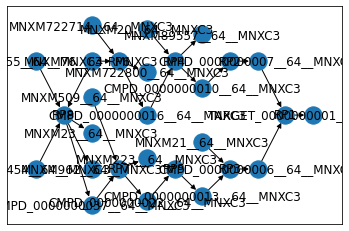

In [9]:
nx.draw_networkx(resG, pos=pos)

In [72]:
200/225

0.8888888888888888

In [74]:
7/8

0.875